## Naming Conventions & Terminology
- clf: classifier
- proba: probabilities

# Chapter 3. Classification

## Classifying the classic MNIST digit dataset

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

C:\Users\BAILEYDuncan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\BAILEYDuncan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [2]:
# X: the array of 70K images
# y: the labels
X, y = mnist["data"], mnist["target"]

In [3]:
# 28 x 28 pixels = 784
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

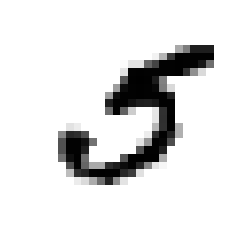

In [6]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [7]:
y[36000]

5.0

In [8]:
# Split our train and test data 60:10
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
import numpy as np

# shuffle data
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier: Is it a five or not?

In [10]:
# Make our five detector
y_train_5 = (y_train == 5) # Create labels (True/False)
y_test_5 = (y_test == 5)

### Pick our classifier ?!?

#### Start with Stochastic Gradient Descent (SGD) classifier
#### Properties:
- handles very large datasets efficiently
- processes training instances independently, making it good for **online learning**


In [11]:
from sklearn.linear_model import SGDClassifier
# Add: max_iter=5, tol=-np.infty because of updates
sgd_clf = SGDClassifier(random_state=42, max_iter=5, tol=-np.infty) # Relies on random (stochastic). Set random_state so results are reproduced
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

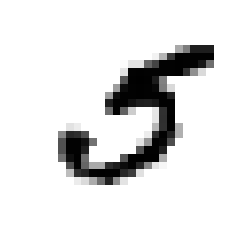

In [12]:
# Lets try our model on this image...
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [13]:
sgd_clf.predict([some_digit])

array([ True])

### Now we know it works for one, lets properly evaluate the model's performance...

### performance measures:
- cross-validation
- confusion matrix

The StratifiedKFold class performs stratified sampling (as explained in Chapter 2) to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.


In [14]:
# Implement our own cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42) # creates K=3 folds... 
                                                       # i.e. split training data into 3 sets to train 3 copies of the model on

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9375
0.96355
0.9649


In [15]:
# Use SKLearn cross-validation
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9375 , 0.96355, 0.9649 ])

#### 95% sounds too good, we are going to see how many fives there really are by making a dummy classifier that never guesses 5's

In [16]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91035, 0.90875, 0.90985])

**90% are not 5's!**
**This is why accuracy is generally not a preferred measure for classifiers, especially because of skewed datasets**

### Confusion Matrix is better
#### Count the number of times the classifier confuses a number with a different one... count wrong answers.

In [18]:
from sklearn.model_selection import cross_val_predict

# Cross_val_predict uses folds to predict values in each fold (it returns predicted values instead of scores)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [19]:
from sklearn.metrics import confusion_matrix

# Create a confusion matrix:
#       Rows: actual class
#       Columns: predicted class

confusion_matrix(y_train_5, y_train_pred)

array([[52892,  1687],
       [  994,  4427]], dtype=int64)

In [20]:
# This is what a 100% accurate model looks like
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Formulas
Precision of the classifier:
**precision = TP / (TP + FP)**
- TP: True Positives
- FP: False Positives

Recall, sensitivity, or true positive rate(TPR)... the ratio of positive instances that are correctly detected by the classifier:
**recall = TP / (TP + FN)**
- FN: false negatives


In [21]:
#    TN | FP
#   ----------
#    FN | TP

In [22]:
# Compute Precision & Recall
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) # Detects 79% of the 5's

0.7240758913967943

In [23]:
recall_score(y_train_5, y_train_pred) # 78% of the time it is right when it predicts a five

0.8166389964951116

It is convenient to combine precision & recall scores into an **F1 score**. An F1 score is a harmonic mean of precision and recall. A regular mean treats values equally, but a harmonic mean gives higher weight to low values. I.E. both precision and recall must be high to get a high score.

**F1 = 2 /( (1/precision) + (1/recall) ) = 2 x (precision x recall) / (precision + recall) = TP / (TP + (FN + FP)/2)**

In [24]:
# Compute F1 Score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7675769397485912

In [25]:
# increasing precision reduces recall, and vice-versa. This is the precision/recall paradox.

### Thresholds for Decision/Recall Tradeoffs

| - | Negative Predictions  | Balanced | Positive Predictions  |
|---|---|---|---|
| **Precision**  |  LOW | MED  | HIGH  |
| **Recall**  |  HIGH | MED  | LOW  |

In [26]:
# Trying to identify the thresholds...
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([52666.07396831])

In [27]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [28]:
# Confirm that changing threshold changes score?
threshold = -34000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [29]:
# Get the decision scores of all instances in training set (instead of predictions)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [30]:
y_scores.shape

(60000,)

In [31]:
# hack to work around issue #9589 in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]
y_scores.shape

(60000,)

In [32]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

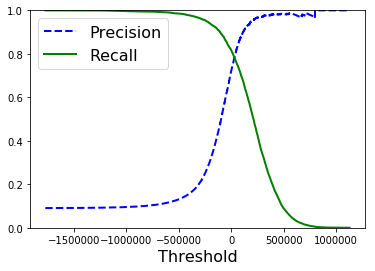

In [33]:

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [34]:
# Tune threshold to get 90% precision... (based on the chart looks like 250,000 is good but low recall)
y_train_pred_90 = (y_scores > 250000)
precision_score(y_train_5, y_train_pred_90)

0.9672544080604534

In [35]:
recall_score(y_train_5, y_train_pred_90)

0.42501383508577756

## ROC Curve 
Reciever operating characteristic curve is an alternative to using the precision/recall curve. It plots true positive rate (TPR) against false positive rate (FPR). 

- FPR is the ratio of negative instances that are incorrectly classified as positive. 

- TNR is also known as specificity

**FPR = 1 - True Negative Rate**

**ROC plots sensitivity (recall) vs. 1 - specificity**

In [36]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

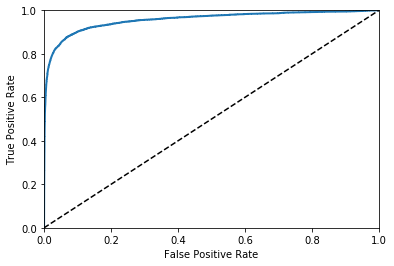

In [37]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

### Notice: the higher the recall (TPR), the more false positives we get

#### The dotted line represents a completely random classifier... so a good classifier will stay as close to the top left corner as possible

#### You can compare classifiers by using the Area under the Curve (AUC):
- Perfect : 1.0
- Purely Random: 0.5

In [38]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9567212066319358

### ROC Curve vs. Precision/Recall (PR) Curve
- Use PR Curve when the positive class is rare, or false positives are more important than false negatives
- Use ROC Curve when positive class is common, or false negatives are more important

In [39]:
# Train Random Forest Classifier to compare to SGD Classifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=4, method="predict_proba")

C:\Users\BAILEYDuncan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\BAILEYDuncan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\BAILEYDuncan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\BAILEYDuncan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [40]:
# To plot ROC curve we need scores not probabilities ("probas"). 
# We'll use the positive classes probability as the score
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

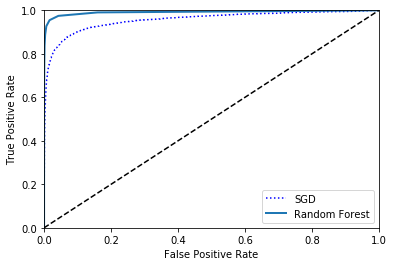

In [41]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [42]:
roc_auc_score(y_train_5, y_scores_forest)

0.9915585064051131

### The random forest is much better than our SGD classifier!

## Multiclass Classification (Multinominal Classifiers)
### Binary Classifiers:
- Support Vector Machine Classifiers (SVM)
- Linear Classifiers...

### Multiclass Classifiers
- Random Forest Classifiers
- Bayes Classifiers...

#### There are techniques to combine binary classifiers to create a multiclass classifier.
- One-versus-all (OvA) strategy or one-versus-the-rest: create a binary classifier for each class and pick whichever has the highest score.
- One-versus-one (OvO) strategy: train a binary classifier for each pair of classes. For N classes, you train N x (N-1)/2 classifiers. (The strength of this is that you can use **very small subsets** of your data to train each classifier because you only need the two classes data)
- SVM's scale poorly with the size of the training set, so its better to use OvO. That way you can train many classifiers on small training sets faster than it would take to train few classifiers on large training sets.

#### Scikit-Learn automatically uses OvA when you try to use binary classifiers for multiclass classification tasks (unless you use SVM classifiers in which case it will use OvO)

In [43]:
# Train 10 SGD classifiers (Class 0-9) in OvA Configuration
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

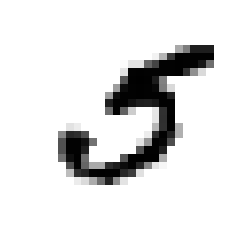

array([5.])

In [44]:
# Display the number
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

# Display our models prediction
sgd_clf.predict([some_digit])

In [45]:
# Show scores for all 10 classifiers
some_digit_scores = sgd_clf.decision_function([some_digit]) # Lets look at all the scores
some_digit_scores

array([[ -29893.96150504, -394960.52447895, -422801.70497374,
        -167673.77760609, -446799.45162616,   52666.07396831,
        -728921.88140204, -351479.5539186 , -503968.69600111,
        -698032.01575157]])

In [46]:
np.argmax(some_digit_scores)

5

In [47]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [48]:
sgd_clf.classes_[5]

5.0

In [49]:
# We can force scikit learn to use OneVsOne or OneVsRest Classifiers
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

C:\Users\BAILEYDuncan\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\BAILEYDuncan\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\BAILEYDuncan\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they

C:\Users\BAILEYDuncan\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\BAILEYDuncan\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\BAILEYDuncan\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they

C:\Users\BAILEYDuncan\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\BAILEYDuncan\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\BAILEYDuncan\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they

array([5.])

In [50]:
len(ovo_clf.estimators_)

45

In [51]:
# Training a RandomForestClassifier is also very easy
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

C:\Users\BAILEYDuncan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([5.])

In [52]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.1, 0. , 0.9, 0. , 0. , 0. , 0. ]])

In [53]:
# Now we evaluate the classifiers with cross validation (remember K-Folds)
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86202759, 0.87099355, 0.84407661])

#### over 80% is good. A random classifier would have 10% chance

In [54]:
# Lets scale the inputs to increase the accuracy
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [55]:
# I'm guessing this means we normalize the pixels from 0-255 to 0-1?
# It could also mean subtracting the mean pixel value from each...
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [56]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90941812, 0.91144557, 0.91008651])

### If this were a real project, we would explore data preparation options, try multiple models (shortlisting the best), fine-tune our hyperparameters with GridSearchCV, and automate as much as possible.

### We will skip this for this example.

## Error Analysis

In [57]:
# Lets look at our confusion matrix:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5747,    3,   18,    7,   11,   44,   39,   10,   39,    5],
       [   1, 6489,   45,   26,    6,   42,    7,   13,  102,   11],
       [  54,   37, 5351,   90,   83,   26,   87,   64,  150,   16],
       [  45,   42,  143, 5350,    2,  233,   34,   54,  134,   94],
       [  24,   29,   36,    8, 5364,    9,   48,   30,   89,  205],
       [  78,   45,   40,  188,   72, 4593,  107,   22,  170,  106],
       [  37,   25,   52,    3,   45,   89, 5614,    7,   45,    1],
       [  30,   21,   68,   31,   50,    8,    3, 5786,   19,  249],
       [  53,  157,   71,  161,   11,  147,   54,   24, 5034,  139],
       [  45,   33,   28,   88,  161,   28,    2,  188,   85, 5291]],
      dtype=int64)

<function matplotlib.pyplot.show(*args, **kw)>

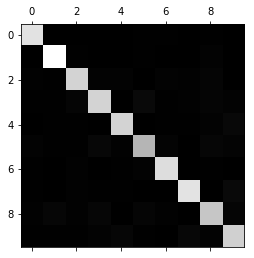

In [58]:
# Looking at am image representation can also help better understand it rather 
# than seeing just the numbers
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show

### Our matrix looks good, as the cells in the main diagonal are classified correctly (0 is classified as 0, 1 is classified as 1...). The darkest is 5, which either means we have less 5's in our training set, or the classifier doesn't perform well on 5's

In [59]:
# Now lets remove all the correct predicions so we only see the errors
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

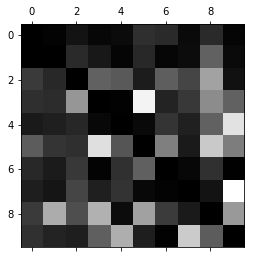

In [60]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [61]:
# Rows = actual classes
# Cols = predicted classes

### What can we see?
- Cols 8/9 are very bright. This means many images get misclassified as 8 & 9's
- Rows 8/9 are also bright, meaning many 8's & 9's are classified as other numbers
- The rows/cols for 1 is dark, they are the most correctly classified
- 3's and 5's are often confused (those two very white squares)

In [62]:
cl_a, cl_b = 3, 5

# digits classified as 3's
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]

# digits classified as 5's
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [63]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

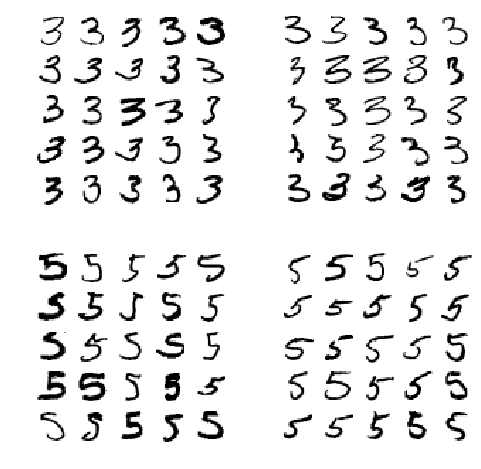

In [64]:
# display digits classified as 3's on LHS, 5's RHS
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)

plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

#### We are using a SGDCLassifier which is a linear model. It simply assigns a weight per class to each pixel, when it see's a new image it jsut sums up the weighted pixel instensities to get a score for each class. Since 3's & 5's differ by only a few pixels the model will be easily confused by them! Our classifier is quite sensitive to shifting and rotations.

#### We could preprocess the image to ensure they are well centered and not too rotated to reduce the errors.

### Multilabel Classification
#### Sometimes you need multiple classes per instance.

In [65]:
from sklearn.neighbors import KNeighborsClassifier

# Create an array with two target labels: 1. is the digit large? 2. is the digit odd?
y_train_large = (y_train >=7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [66]:
# Train our multilabel classifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [67]:
# predict on our drawing of 5. (Not large and odd)
knn_clf.predict([some_digit])

array([[False,  True]])

In [68]:
# How to evaluate a multilabel classifier?
# One way is to use the F1 score for each individual label then calculate the average score

# THESE RUN FOR A LONG TIME!
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")  # Assumes all labels are equal


0.968779238296509

## Multioutput Classification (multioutput-multiclass classification)
### Multiclass Classification where each label can be a multiclass

In [71]:
# Lets try adding some noise to our pixel intensities
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

In [77]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

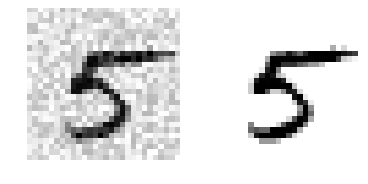

In [79]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

In [83]:
# Now lets train a model to remove the noise
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

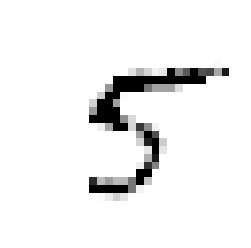

In [84]:
# See our result
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)